## BERT Transformer

In [1]:
# Load Huggingface transformers
from transformers import TFBertModel, BertConfig, BertTokenizerFast

# Then what you need from tensorflow.keras
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical

# Libraries to import and process the data set
from Utilities import directories
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split
from datetime import datetime

# Visualization
import matplotlib.pyplot as plt

# Stuff that makes the notebook look nicer
import warnings
warnings.filterwarnings('ignore')

In [2]:
### --------- Load and transform data ---------- ###
with open(directories.data + "/example_extract.txt", "rb") as file:   # Unpickling
    data = pickle.load(file)

# Transfer data to pandas ds and set model output (classes) as categorical
data_df = pd.DataFrame(data, index=['Description', 'CPC_label']).transpose()
data_df['CPC_label'] = pd.Categorical(data_df['CPC_label'])
# Transform output to numeric
data_df['CPC_code'] = data_df['CPC_label'].cat.codes
# Split into train and test
train, test = train_test_split(data_df, test_size = 0.1)
print(len(train), len(test))

43 5


In [3]:
test

,Description,CPC_label,CPC_code
16,<h4>CROSS-REFERENCE TO RELATED APPLICATIONS</h...,A61K,4
13,<h4>CROSS-REFERENCE TO RELATED APPLICATIONS</h...,A61K,4
39,"<h4>FIELD OF THE INVENTION</h4><p id=""p-0002"" ...",A61K,4
19,"<h4>BACKGROUND OF INVENTION</h4><p id=""p-0002""...",A61K,4
2,<h4>CROSS-REFERENCE TO RELATED APPLICATION</h4...,A23G,1
4,"<p id=""p-0003"" num=""0001"">[0001] This is an ap...",A61K,4
33,"<h4>FIELD OF THE INVENTION</h4><p id=""p-0002"" ...",A61K,4
47,"<h4>RELATED APPLICATIONS</h4><p id=""p-0002"" nu...",A61K,4
28,<h4>CROSS REFERENCE TO RELATED APPLICATIONS</h...,A61P,6
44,"<p id=""p-0002"" num=""0001"">[0001] This applicat...",F16K,12


In [4]:
### --------- Setup BERT ---------- ###
# Name of the BERT model to use
model_name = 'bert-base-uncased'
# Max length of tokens
max_length = 100
# Load transformers config and set output_hidden_states to False
# from_pretrained loads weights from pretrained model
config = BertConfig.from_pretrained(model_name)
config.output_hidden_states = False
# Load BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained(pretrained_model_name_or_path = model_name, config = config)
# Load the Transformers BERT model
transformer_model = TFBertModel.from_pretrained(model_name, config = config)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [5]:
# View default configurations
config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "type_vocab_size": 2,
  "vocab_size": 30522
}

In [6]:
### ------- Build the model ------- ###
# Load the MainLayer
bert = transformer_model.layers[0]

# Build your model input
input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')
inputs = {'input_ids': input_ids}

# Load the Transformers BERT model as a layer in a Keras model
bert_model = bert(inputs)[1]
dropout = Dropout(config.hidden_dropout_prob, name='pooled_output')
pooled_output = dropout(bert_model, training=False)

# Then build your model output
cpc_class = Dense(units=len(data_df.CPC_code.value_counts()), kernel_initializer=TruncatedNormal(stddev=config.initializer_range), name='cpc')(pooled_output)
outputs = {'cpc': cpc_class}

# And combine it all in a model object
model = Model(inputs=inputs, outputs=outputs, name='BERT_MultiLabel_MultiClass')

# Take a look at the model
model.summary()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

In [7]:
### ------- Set hyperparameters and input and output ------- ###
# Set an optimizer
optimizer = Adam(
    learning_rate=5e-05,
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)

# Set loss and metrics
loss = {'cpc': CategoricalCrossentropy(from_logits = True)} # Using from_logits=true means that the prediction tensor is
                                                            # one hot encoded. By default, it expects a probability
                                                            # distribution
metric = {'cpc': CategoricalAccuracy('accuracy')}

# Compile the model
model.compile(
    optimizer = optimizer,
    loss = loss,
    metrics = metric)

# Ready output data for the model
y_cpc = to_categorical(train['CPC_code'], num_classes=16)

# Tokenize the input (takes some time)
x = tokenizer(
    text=train['Description'].to_list(),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = False,
    verbose = True)

In [8]:
# One hot vector of 38 sequences x 16 classes
print(y_cpc)

# 38 sequences x 100 token ids because of max_length=100
print(x['input_ids'].shape)

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.

In [9]:
### ------- Train ------- ###
# Fit the model
history = model.fit(
    x={'input_ids': x['input_ids']},
    y={'cpc': y_cpc},
    validation_split=0.1,
    batch_size=32,
    epochs=10)

Epoch 1/10
2/2 [==============================] - 7s 3s/step - loss: 2.9071 - accuracy: 0.0294 - val_loss: 2.5473 - val_accuracy: 0.7500
Epoch 2/10
2/2 [==============================] - 3s 1s/step - loss: 2.6017 - accuracy: 0.3235 - val_loss: 2.4613 - val_accuracy: 0.5000
Epoch 3/10
2/2 [==============================] - 2s 1s/step - loss: 2.4870 - accuracy: 0.3529 - val_loss: 2.2356 - val_accuracy: 0.5000
Epoch 4/10
2/2 [==============================] - 3s 1s/step - loss: 2.4156 - accuracy: 0.3824 - val_loss: 2.1750 - val_accuracy: 0.5000

In [10]:
### ----- Evaluate the model ------ ####
# Evaluate test data
y_cpc_test = to_categorical(test['CPC_code'], num_classes=16)
test_x = tokenizer(
    text=test['Description'].to_list(),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = False,
    verbose = True)# Run evaluation
model_eval = model.evaluate(
    x={'input_ids': test_x['input_ids']},
    y={'cpc': y_cpc_test}
)

1/1 [==============================] - 0s 1000us/step - loss: 1.9004 - accuracy: 0.7000


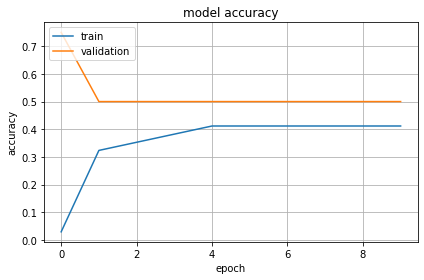

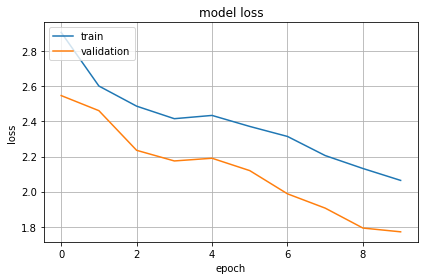

In [16]:
### ----- Visualize training history ------ ####
# summarize history for accuracy
fig1 = plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.grid()
plt.tight_layout()
plt.show()
# summarize history for loss
fig2 = plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.grid()
plt.tight_layout()
plt.show()

In [19]:
### ----- Save the model and figures to disk ------ ####
save_dir = directories.savedModels + "/InitialTestModel"
timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
fig1.savefig(save_dir + "/accuracy_" + timestamp, dpi=300)
fig2.savefig(save_dir + "/loss_" + timestamp, dpi=300)
model.save(save_dir + "/" + timestamp)

INFO:tensorflow:Assets written to: E:/MLData/thesis/SavedModels/InitialTestModel/2021-01-11_11-20-55\assets


Adapted from:
https://towardsdatascience.com/multi-label-multi-class-text-classification-with-bert-transformer-and-keras-c6355eccb63a
